In [0]:
import warnings
warnings.filterwarnings("ignore")
import os
import sys
import numpy as np
import torch
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
import  torch.nn as nn
import torch.nn.functional as F
rseed = 42
np.random.seed(rseed)
torch.manual_seed(rseed)
gpu_id = '0'
from joblib import Parallel, delayed
os.environ['CUDA_VISIBLE_DEVICES']=gpu_id
#os.environ['JOBLIB_TEMP_FOLDER'] = '/ksozykinraid/data/tmp/'
from time import time
import torch 
import pandas as pd
import glob2
import json
from tqdm import tqdm
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [0]:
from google.colab import files
files.upload()

Saving layers.py to layers.py
Saving utils.py to utils.py


{'layers.py': b'\n"""\n    multi-sin-conv is an extention of the https://github.com/mravanelli/SincNet\n"""\n\nimport torch\nimport numpy as np\nimport  torch.nn as nn\nimport torch.nn.functional as F\nimport math \n\nclass Flatten(nn.Module):\n    def forward(self, input):\n        return input.view(input.size(0), -1)\n    \nclass Flip(nn.Module):\n    \n    def __init__(self,dim):\n        super(self.__class__, self).__init__()\n        self.dim = dim\n        \n    def forward(self,x):\n        xsize = x.size()\n        dim = x.dim() + dim if self.dim < 0 else self.dim\n        x = x.contiguous()\n        x = x.view(-1, *xsize[dim:])\n        x = x.view(x.size(0), x.size(1), -1)[:, torch.arange(x.size(1)-1, -1, -1), :]\n        return x.view(xsize)\n\n\nclass Sinc(nn.Module):\n    \n    def __init__(self,device=\'cuda\'):\n        super(self.__class__, self).__init__()\n        self.flip = Flip(0)\n        self.device = device\n        \n    def forward(self,band,t_right):\n        

In [0]:
from utils import *

from layers import *

In [0]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.

drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
import zipfile
zip_ref = zipfile.ZipFile('/content/drive/My Drive/Skeleton.zip', 'r')
zip_ref.extractall('./')
zip_ref.close()

In [0]:

import scipy.io
import numpy as np
import pandas as pd

from pathlib import Path
from matplotlib import pyplot as plt

In [0]:
def data_columns():
    
    axes = ['x', 'y', 'z']
    columns = ['head_' + i for i in axes] + \
        ['shoulder_center_' + i for i in axes] + \
        ['spine_' + i for i in axes] + \
        ['hip_center_' + i for i in axes] + \
        ['left_shoulder_' + i for i in axes] + \
        ['left_elbow_' + i for i in axes] + \
        ['left_wrist_' + i for i in axes] + \
        ['left_hand_' + i for i in axes] + \
        ['right_shoulder' + i for i in axes] + \
        ['right_elbow_' + i for i in axes] + \
        ['right_wrist_' + i for i in axes] + \
        ['right_hand_' + i for i in axes] + \
        ['left_hip_' + i for i in axes] + \
        ['left_knee_' + i for i in axes] + \
        ['left_ankle_' + i for i in axes] + \
        ['left_foot_' + i for i in axes] + \
        ['right_hip_' + i for i in axes] + \
        ['right_knee_' + i for i in axes] + \
        ['right_ankle_' + i for i in axes] + \
        ['right_foot_' + i for i in axes]
    
    return columns

In [0]:
data_columns = data_columns()

In [0]:
#https://github.com/woo-chia-wei/kinect-sequence-classification
def import_skeleton_data(action, subject, trial):
    filename = f'Skeleton/a{action}_s{subject}_t{trial}_skeleton.mat'
    #print(Path(filename).is_file())
    #if Path(filename).is_file():
    mat = scipy.io.loadmat(filename)
    return mat['d_skel']
  #  else:
  #      return None

def transform_skeleton_data(action, subject, trial):
    matrices = []
    data = import_skeleton_data(action, subject, trial)
    #print(data.shape)
    if data is None: return None
    #print(data[:,0,0])
    for frame in range(data.shape[2]):
        skelecton_joints = [i + 1 for i in range(20)]
        matrix = data[:,:,frame]
        matrix = np.insert(matrix, 0, skelecton_joints, axis=1)
        matrix = np.insert(matrix, 0, frame, axis=1)
        matrices.append(matrix)
    result = np.vstack(tuple(matrices))
    result = np.insert(result, 0, [[action], [subject], [trial]], axis=1)
    #print(result)
    return result

def transform_skeleton_data_to_df(action, subject, trial):
    data = transform_skeleton_data(action, subject, trial)
    #print(data.shape)
    if data is None: return None
    df = pd.DataFrame(data)
    df.columns = ['action', 'subject', 'trial', 'frame', 'skeleton_joint', 'x', 'y', 'z']
    return df



In [0]:
df = transform_skeleton_data_to_df(2,2,2)
df[df.frame==2.]

,action,subject,trial,frame,skeleton_joint,x,y,z
40,2.0,2.0,2.0,2.0,1.0,-0.083645,0.377327,2.909049
41,2.0,2.0,2.0,2.0,2.0,-0.070505,0.192519,2.911217
42,2.0,2.0,2.0,2.0,3.0,-0.059986,-0.158131,2.917824
43,2.0,2.0,2.0,2.0,4.0,-0.057779,-0.220212,2.865713
44,2.0,2.0,2.0,2.0,5.0,-0.222236,0.064644,2.884611
45,2.0,2.0,2.0,2.0,6.0,-0.251486,-0.186466,2.865487
46,2.0,2.0,2.0,2.0,7.0,-0.252041,-0.402006,2.831291
47,2.0,2.0,2.0,2.0,8.0,-0.249970,-0.455791,2.825836
48,2.0,2.0,2.0,2.0,9.0,0.085632,0.078919,2.885059
49,2.0,2.0,2.0,2.0,10.0,0.146211,-0.184310,2.902335


In [0]:
def change_data(frame):
    keys = np.array(frame['skeleton_joint'])
    joint = 1
    for i in range(len(data_columns)):
       
        if i % 3 == 0:
            assert(data_columns[i][-1] == 'x')

            frame[data_columns[i]] = np.array(frame.x)* np.where(keys ==joint, keys, 0)

        elif (i-1) % 3 == 0:
            assert(data_columns[i][-1] == 'y')
            frame[data_columns[i]] = np.array(frame.y)* np.where(keys ==joint, keys, 0)

        else:
            assert(data_columns[i][-1] == 'z')
            frame[data_columns[i]] = np.array(frame.z)* np.where(keys ==joint, keys, 0)
            joint += 1
    frame = frame.drop(['subject', 'trial', 'frame', 'skeleton_joint', 'x', 'y', 'z'], axis=1)
    return frame

In [0]:
input_channels = 60

In [0]:
subjects = []
for a in range(1,28):
    for s in range(1,9):
        for t in range(1,5):
            try:
                df = transform_skeleton_data_to_df(a, s, t)
                #print(len(df))
                df = change_data(df)
                subjects.append(df)
            except FileNotFoundError:
                pass

In [0]:
new_subjects = []
for df in subjects:
    assert(len(df.action.unique()) == 1)
    
    
    new = pd.DataFrame(columns = list(df))
    
    for col in list(df):
        if col != 'action':
            dat = np.array(df[col])
            dat = dat[dat != 0.]
            new[col] = dat
    new['action'] = df.action.unique()[0]
    new_subjects.append(new)

In [0]:
import torch.utils.data
from sklearn.model_selection import train_test_split
import torch

class SkelDataset(torch.utils.data.Dataset):
  
    def __init__(self, subjects, fold='train'):
        self.fold = fold
        X = []
        Y = []
        for df in subjects:
           
            for i in range(1,28):
                if df.action[0] == i:
                    label = i - 1
                    
                #else:
                #    df[str(i)] = 0.
            df = df.drop(['action'], axis=1)
            #print(df.shape)
            if len(df) < 125:
                h = 125 - len(df)
                zeros = pd.DataFrame(np.zeros((h,60)), columns = list(df))
                df = df.append(zeros, ignore_index=True)
            
            
            #labels = df[[str(i) for i in range(1,28)]]
            #labels = labels.to_numpy()
            #print(labels.shape)
            Y.append(label)
            #df = df.drop([str(i) for i in range(1,28)], axis=1)
            df = df.to_numpy()
            X.append(df)

        X_train, X_, y_train, y_ = train_test_split(X, Y, train_size=0.7, random_state=42)
        X_val, X_test, y_val, y_test = train_test_split(X_, y_, train_size=0.6, random_state=42)
        self.train_data = torch.FloatTensor(X_train)
        self.train_labels = torch.LongTensor(y_train)
        
        self.val_data = torch.FloatTensor(X_val)
        self.val_labels = torch.LongTensor(y_val)
        self.test_data = torch.FloatTensor(X_test)
        self.test_labels = torch.LongTensor(y_test)
      
    def __len__(self):
        if self.fold == 'train':
            return len(self.train_data)
        elif self.fold == 'val':
            return len(self.val_data)
        elif self.fold == 'test':
            return len(self.test_data)
     
            
  

    def __getitem__(self, index):
      
        if self.fold == 'train':
            data = self.train_data[index]
            label =  self.train_labels[index]
        elif self.fold == 'val':
            data = self.val_data[index]
            label =  self.val_labels[index]
        elif self.fold == 'test':
            data = self.test_data[index]
            label =  self.test_labels[index]
        return data,label

In [0]:

train_dataset = SkelDataset(new_subjects,fold='train')

In [0]:

val_dataset = SkelDataset(new_subjects,fold='val')
test_dataset = SkelDataset(new_subjects,fold='test')

In [0]:
class Conv1DNet(nn.Module):
    
    def __init__(self):
        super(self.__class__, self).__init__()
        self.input_bn = nn.BatchNorm1d(input_channels)
        self.conv11 = nn.Conv1d(in_channels=input_channels, out_channels=64, kernel_size=3, padding=1)
        self.pool11 = nn.MaxPool1d(kernel_size=2)
        self.conv21 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.pool21 = nn.MaxPool1d(kernel_size=2)
        self.conv31 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.pool31 = nn.MaxPool1d(kernel_size=2)
        #self.gpool = GlobalMaxPooling()
        self.fc1 = nn.Linear(256*(win_size//(2**3)),512)
        self.fc2 = nn.Linear(512,512)
        self.logit = nn.Linear(512,num_classes)
        
        self.features = nn.Sequential(
             self.input_bn,
             self.conv11,self.pool11,
             nn.ReLU(),                            
             self.conv21,self.pool21,
             nn.ReLU(),
             self.conv31,self.pool31,
             nn.ReLU(),
             Flatten(),
        )
        
        self.classifier = nn.Sequential(
             self.fc1,
             nn.ReLU(),
             self.fc2,
             nn.ReLU(),
             self.logit,
        )
        
    def forward(self,input):
        features = self.features(input)
        return self.classifier(features)


In [0]:
class MultiSincNet(nn.Module):
    
    def __init__(self,
                 N_filt = 12,  
                 Filt_dim = 5, 
                 fs = 100,
                 device = "cuda"):
        super(self.__class__, self).__init__()
        self.input_bn = nn.BatchNorm1d(input_channels)
        self.fs = fs
        self.device = device
        self.sincconv = multichannel_sinc_conv(Filt_dim=Filt_dim,
                                  N_channels=input_channels,
                                  N_filt=N_filt,
                                  fs=fs,
                                  device = device, cutfreq_type = 'random')
        self.layer_norm = LayerNorm(win_size-Filt_dim+1)
        self.conv11 = nn.Conv1d(in_channels=720, out_channels=64, kernel_size=3, padding=1)
        self.pool11 = nn.MaxPool1d(kernel_size=2)
        self.conv21 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.pool21 = nn.MaxPool1d(kernel_size=2)
        self.conv31 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.pool31 = nn.MaxPool1d(kernel_size=2)
        #self.gpool = GlobalMaxPooling()
        self.fc1 = nn.Linear(3840,512)
        self.fc2 = nn.Linear(512,512)
        self.logit = nn.Linear(512,num_classes)
        
        self.features = nn.Sequential(
             self.input_bn,
             self.sincconv,
             #self.layer_norm,
             self.conv11,
             nn.LeakyReLU(),
             self.pool11,
             nn.LeakyReLU(),                            
             self.conv21,self.pool21,
             nn.LeakyReLU(),
             self.conv31,self.pool31,
             nn.LeakyReLU(),
             Flatten(),
        )
        
        self.classifier = nn.Sequential(
             self.fc1,
             nn.LeakyReLU(),
             self.fc2,
             nn.LeakyReLU(),
             self.logit,
        )
        
    def forward(self,input):
        features = self.features(input)
        return self.classifier(features)

In [0]:
class Conv1DLstmNet(nn.Module):
    
    def __init__(self):
        super(self.__class__, self).__init__()
        self.input_bn = nn.BatchNorm1d(input_channels)
        self.conv11 = nn.Conv1d(in_channels=input_channels, out_channels=64, kernel_size=3, padding=1)
        self.pool11 = nn.MaxPool1d(kernel_size=2)
        self.conv21 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.pool21 = nn.MaxPool1d(kernel_size=2)
        self.conv31 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.pool31 = nn.MaxPool1d(kernel_size=2)
        self.lstm1 = nn.LSTM(input_size=256,hidden_size=512,batch_first=True)
        #self.fc1 = nn.Linear(2*win_size*(win_size//(2**3)),512)
        self.fc1 = nn.Linear(7680,512)
        self.fc2 = nn.Linear(512,512)
        self.logit = nn.Linear(512,num_classes)
        
        self.features = nn.Sequential(
             self.input_bn,
             self.conv11,self.pool11,
             nn.ReLU(),                            
             self.conv21,self.pool21,
             nn.ReLU(),
             self.conv31,self.pool31,
             nn.ReLU(),
        )
        

        
        self.classifier = nn.Sequential(
             self.fc1,
             nn.ReLU(),
             self.fc2,
             nn.ReLU(),
             self.logit,
        )
        
    def forward(self,input):
        features = self.features(input).transpose(1, 2)
        features, (hn,cn) = self.lstm1(features)
        features = Flatten()(features.transpose(1, 2).contiguous())
        return self.classifier(features)

In [0]:
class MultiSincLstmNet(nn.Module):
    
    def __init__(self,
                 N_filt = 12,  
                 Filt_dim = 5, 
                 fs = 100,
                 device = "cuda"):
        super(self.__class__, self).__init__()
        self.input_bn = nn.BatchNorm1d(input_channels)
        self.fs = fs
        self.device = device
        self.sincconv = multichannel_sinc_conv(Filt_dim=Filt_dim,
                                  N_channels=input_channels,
                                  N_filt=N_filt,
                                  fs=fs,
                                  device = device, cutfreq_type = 'random')
        self.layer_norm = LayerNorm(win_size-Filt_dim+1)
        self.conv11 = nn.Conv1d(in_channels=720, out_channels=64, kernel_size=3, padding=1)
        self.pool11 = nn.MaxPool1d(kernel_size=2)
        self.conv21 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.pool21 = nn.MaxPool1d(kernel_size=2)
        self.conv31 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.pool31 = nn.MaxPool1d(kernel_size=2)
        self.lstm1 = nn.LSTM(input_size=256,hidden_size=512,batch_first=True)
        self.fc1 = nn.Linear(7680,512)
        self.fc2 = nn.Linear(512,512)
        self.logit = nn.Linear(512,num_classes)
        
        self.features = nn.Sequential(
             self.input_bn,
             self.sincconv,
             #self.layer_norm,
             self.conv11,
             nn.LeakyReLU(),
             self.pool11,
             nn.LeakyReLU(),                            
             self.conv21,self.pool21,
             nn.LeakyReLU(),
             self.conv31,self.pool31,
             nn.LeakyReLU(),
        )
        
        self.classifier = nn.Sequential(
             self.fc1,
             nn.LeakyReLU(),
             self.fc2,
             nn.LeakyReLU(),
             self.logit,
        )
        

                
    def forward(self,input):
        features = self.features(input).transpose(1, 2)
        features, (hn,cn) = self.lstm1(features)
        features = Flatten()(features.transpose(1, 2).contiguous())
        return self.classifier(features)

In [0]:
def roll2(x, n):  
    return torch.cat((x[:, :, -n:], x[:, :, :-n]), dim=2)

In [0]:
class get_features_isotropy(nn.Module):

    def __init__(self, hidden_ch=32, krnl=32):
        super(get_features_isotropy,self).__init__()
        self.hidden_ch = hidden_ch
        self.conv1 = nn.Conv1d(12, hidden_ch, krnl)
        self.fc1 = nn.Conv1d(hidden_ch, 1, 1)
        self.fc2 = nn.Conv1d(hidden_ch, 1, 1)
        self.conv2 = nn.Conv1d(15, hidden_ch, krnl)
        self.krnl = krnl

    def forward(self, x):
        #print(x.shape)
        h = x.clone().reshape(-1, 60, win_size).transpose(1, 2).reshape(-1, win_size, 5, 4, 3) # we will leave only the acceleration rows unchanged
        h1 = h.clone()
        for body_part in range(3):
            for orientation in range(3):
                h1[:, :, body_part, 1, orientation] = self.fc1(F.leaky_relu(self.conv1(F.pad(roll2(h[:, :, body_part], orientation).reshape(-1, win_size, 12), (0, 0, self.krnl-1, 0)).transpose(1, 2)))).reshape(-1, win_size)
        h = torch.cat((h, h1[:, :, :, 1:2, :]), dim=3)
        for body_part in range(3):
            for orientation in range(3):
                h1[:, :, body_part, 2, orientation] = self.fc2(F.leaky_relu(self.conv2(F.pad(roll2(h[:, :, body_part], orientation).reshape(-1, win_size, 15), (0, 0, self.krnl-1, 0)).transpose(1, 2)))).reshape(-1, win_size)
        #return h1.reshape(-1, win_size, 27).transpose(1, 2).contiguous()
        return h1.reshape(-1, win_size*60)

In [0]:

class IsotropyNet(nn.Module):
    
    def __init__(self, krnl=32,
                 device = "cuda"):
        super(self.__class__, self).__init__()
        self.input_bn = nn.BatchNorm1d(input_channels)
        self.device = device
        #self.lin = nn.Linear(60, 27)
        self.isotropic_features = get_features_isotropy(krnl=krnl)
        self.fc1 = nn.Linear(7500, 512)
        self.fc2 = nn.Linear(512, 64)
        #self.lstm1 = nn.LSTM(input_size=win_size,hidden_size=512,batch_first=True)
        self.logit = nn.Linear(64,num_classes)
        
        self.classifier = nn.Sequential(
             self.input_bn,
             self.isotropic_features,
             #Flatten(),
             self.fc1,
             nn.LeakyReLU(),
             self.fc2,
             nn.LeakyReLU(),
             self.logit,
        )
        

                
    def forward(self,input):
        #features = self.features(input).transpose(1, 2)
        #features, (hn,cn) = self.lstm1(features)
        #features = Flatten()(features.transpose(1, 2).contiguous())
        #input = torch.transpose(input, 1, 2)
        #input = self.lin(input)
        #input = torch.transpose(input, 1, 2)
        return self.classifier(input)

In [0]:
class IsotropyMultiSincLstmNet(nn.Module):
    def __init__(self,
                 N_filt = 12,  
                 Filt_dim = 5, 
                 fs = 100,
                 device = "cuda"):
        super(self.__class__, self).__init__()
        self.isotropy = get_features_isotropy()
        self.net = MultiSincLstmNet(N_filt = N_filt, Filt_dim = Filt_dim, fs = fs, device = device)
    def forward(self,input):
        print(self.isotropy(input.transpose(1, 2)).shape)
        return self.net(self.isotropy(input))

In [0]:
class IsotropyConv1DNet(nn.Module):
    def __init__(self):
        super(self.__class__, self).__init__()
        self.isotropy = get_features_isotropy()
        self.net = Conv1DNet()
    def forward(self,input):
        return self.net(self.isotropy(input.transpose(1, 2)).transpose(1, 2))

In [0]:
num_epochs = 50
verbose = 5
batch_size = 1024
device = "cuda"

In [0]:
def compute_loss(reference, prediction):
    """
    
    """
    reference = reference.to(device)
    #reference = torch.argmax(reference,dim=-1).to(torch.long)
    prediction = prediction.log_softmax(dim=-1)
    loss = nn.NLLLoss()(prediction,reference)
    return loss
  
def compute_acc(reference, prediction):
    """
    
    """
    reference = reference.to(device)
    prediction = torch.argmax(prediction.log_softmax(dim=-1),dim=-1)
   # reference = torch.argmax(reference,dim=-1)
    return (reference == prediction).to(torch.float32).mean()

In [0]:
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size*4,shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset,batch_size=batch_size,shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=batch_size,shuffle=False)

In [0]:
win_size=125
num_classes = 27

In [0]:
#model = Conv1DLstmNet().to(device)
#model = Conv1DNet().to(device)
#model = MultiSincNet(device=device).to(device)
#model = MultiSincLstmNet(device=device).to(device)
model = IsotropyNet(krnl=32).to(device)



In [0]:
opt = torch.optim.Adam(model.parameters(), lr=1e-3,weight_decay=1e-5)

best_acc = 0.
best_loss = np.inf
sPATH = ''
fmt_str = '/content/%s_%dclass_%.4f.pth'

epoch_wo_progress=0

In [0]:

from collections import  defaultdict
report  = defaultdict(list)

In [0]:
from IPython import display

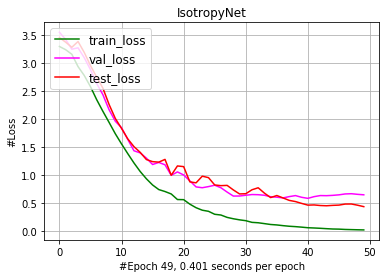

49	Training:
	Loss:	0.02070
	ACC:	1.00000
49	Validation:
	BEST VAL loss:	0.58445
	Loss:	0.64776
	val ACC:	0.82581
49	Testing:
	Loss:	0.43631
	test ACC:	0.84615




In [0]:
for epoch in range(num_epochs):
    train_loss = train_acc = train_batches = 0 
    train_acc_fixed = 0
    model.train()
    y_true,y_pred = [],[]
    start = time.time()
    for batch in train_loader:
        
        data,reference = batch
        data = data.transpose(1, 2).to(device)
        #print(data.shape)
#        print(data.transpose(1, 2).shape)
        prediction = model(data)
        y_true.append(reference)
        y_pred.append(prediction)
        loss = compute_loss(reference, prediction)
        loss.backward()
        opt.step()
        opt.zero_grad()
        
        with torch.no_grad():
            train_loss += loss.item()
            train_batches += 1
    y_true = torch.cat(y_true,dim=0)
    y_pred = torch.cat(y_pred,dim=0)
    
    with torch.no_grad():
        train_acc += compute_acc(y_true, y_pred).cpu().numpy()
    
    val_loss = val_acc = val_batches = 0
    val_acc_fixed = 0
    #model.train(False)
    model.eval()
    y_true,y_pred = [],[]
    for batch in val_loader:
        data,reference = batch
        
        #reference = torch.cat([reference]*)
        
        data = data.transpose(1, 2).to(device)
        prediction = model(data)
        y_true.append(reference)
        y_pred.append(prediction)
        loss = compute_loss(reference, prediction)
        with torch.no_grad():
            val_loss += loss.item()
            
            val_batches += 1
    y_true = torch.cat(y_true,dim=0)
    y_pred = torch.cat(y_pred,dim=0)
    with torch.no_grad():
        val_acc += compute_acc(y_true, y_pred).cpu().numpy()
    #val_acc = (val_acc / val_batches)
    val_loss = (val_loss / val_batches)
    
    y_true,y_pred = [],[]
    test_loss = test_acc = test_batches = 0
    for batch in test_loader:
        data,reference = batch
        data = data.transpose(2,1).to(device)
        prediction = model(data)
        y_true.append(reference)
        y_pred.append(prediction)
        #print(len(reference),len(prediction))
        loss = compute_loss(reference, prediction)
        with torch.no_grad():
            test_loss += loss.item()
            
            test_batches += 1
    y_true = torch.cat(y_true,dim=0)
    y_pred = torch.cat(y_pred,dim=0)
    with torch.no_grad():
        test_acc += compute_acc(y_true, y_pred).cpu().numpy()
    #test_acc = (test_acc / test_batches)
    
    test_loss = (test_loss / test_batches)
    
    
    
    if val_loss < best_loss:
        epoch_wo_progress=0
        best_loss = val_loss
     
        if sPATH != '' and os.path.exists(sPATH):
            os.remove(sPATH)
        sPATH = fmt_str % (model.__class__.__name__,num_classes,best_loss)
        torch.save(model.state_dict(),sPATH)
   
        
    else:
        epoch_wo_progress += 1
#        if epoch_wo_progress>15:
#            print("Early Stopping")
#            break
    report['train_loss'].append(train_loss / train_batches)
    report['val_loss'].append(val_loss)
    report['test_loss'].append(test_loss)
    finish = time.time()
    time_epoch = finish-start    
    display.clear_output(wait=True)
    fig = plt.Figure(figsize=(20,20),facecolor='white')
    plt.plot(report['train_loss'],color='green',label='train_loss')
    plt.plot(report['val_loss'],color='magenta',label='val_loss')
    plt.plot(report['test_loss'],color='red',label='test_loss')
    plt.xlabel("#Epoch %d, %.3f seconds per epoch" % (epoch,time_epoch))
    plt.ylabel("#Loss")
    plt.title(model.__class__.__name__)
    legend(loc=2, prop={'size': 12})
    plt.grid()
    plt.show()
    
    print("%d\tTraining:" % (epoch))
        
    print("\tLoss:\t%.5f" % (train_loss / train_batches))
    print("\tACC:\t%.5f" % (train_acc))
    print("%d\tValidation:" % (epoch))
    print("\tBEST VAL loss:\t%.5f" % best_loss)
    print("\tLoss:\t%.5f" % val_loss)
    print("\tval ACC:\t%.5f" % val_acc)
    print("%d\tTesting:" % (epoch))
    print("\tLoss:\t%.5f" % (test_loss / test_batches))
    print("\ttest ACC:\t%.5f" % test_acc)
    print('\n')
    
    
    if epoch  % verbose == 0 or epoch == num_epochs - 1:
        pass

In [0]:
model.load_state_dict(torch.load(sPATH))
model.eval();

In [0]:
y_pred_np = torch.argmax(y_pred.log_softmax(dim=-1),dim=-1).detach().cpu().numpy()

In [0]:

np.unique(y_pred_np) == np.unique(y_true) 
assert len(y_true) == len(test_dataset)

In [0]:
n_conf = 28

In [0]:
creport = pd.DataFrame((classification_report(y_true,y_pred_np,output_dict=True)))
acc = accuracy_score(y_true,y_pred_np)
fm_score = []
for i in range(n_conf):
    try:
        fm_score.append(creport[str(i)]['f1-score'])
    except:
        pass

In [0]:

np.mean(fm_score)

0.8455406733184511

In [0]:
def plot_confusion_matrix(df_confusion, title='Confusion matrix', cmap=plt.cm.jet):
    """
        https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels/48018785
    """
    plt.figure(figsize=(15,15),facecolor='white')
    plt.matshow(df_confusion, cmap=cmap, fignum=1) # imshow
    #plt.title("%s" % (model.__class__.__name__))
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.index, rotation=90)
    plt.yticks(tick_marks, df_confusion.index)
    #plt.tight_layout()
    plt.ylabel(df_confusion.index.name, fontsize=12)
    plt.xlabel(df_confusion.columns.name, fontsize=12)
   
    plt.show()

In [0]:

activities = ['right arm swipe to the left', 'right arm swipe to the right', 'right hand wave', 'two hand front clap', 'right arm throw', 'cross arms in the chest', 'basketball shoot',
              'right hand draw x', 'right hand draw circle (clockwise)', 'right hand draw circle (counter clockwise)', 'draw triangle', 'bowling (right hand)', 'front boxing', 
              'baseball swing from right', 'tennis right hand forehand swing', 'arm curl (two arms)', 'tennis serve', 'two hand push', 'right hand knock on door', 
              'right hand catch an object', 'right hand pick up and throw', 'jogging in place', 'walking in place', 'sit to stand', 'stand to sit', 'forward lunge (left foot forward)',
              'squat (two arms stretch out)']
        

##IsotropyNet

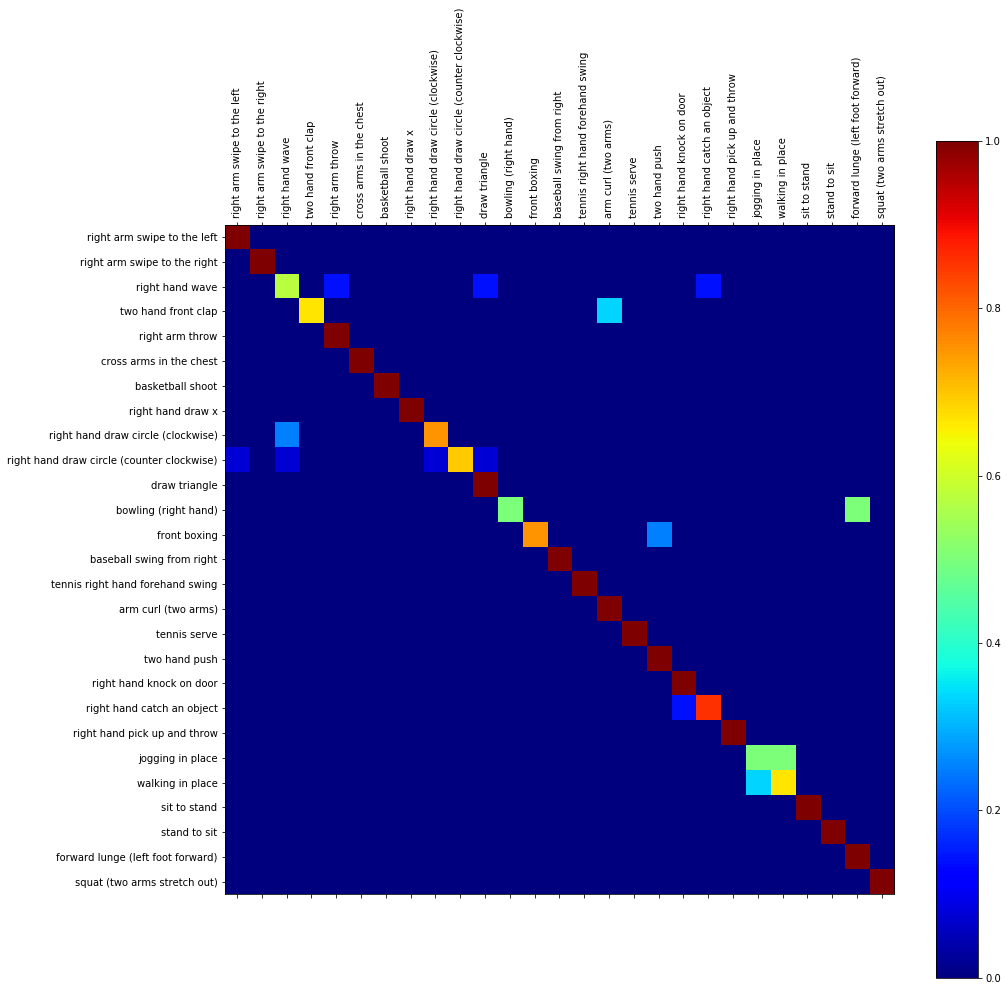

In [0]:
# rope jumping corrupting color scheme
cm  = create_conf_matrix(y_true,y_pred_np,n_classes=27)#len(activities))
cmdf = pd.DataFrame(cm/cm.sum(1)[:, None])
cmdf.columns = activities
cmdf.index = activities

plot_confusion_matrix(cmdf)

In [0]:
cmdf.to_excel('/content/iso.xlsx')

In [0]:
print("%s\t%d\t%.4f\t%.4f" %(model.__class__.__name__,num_classes,np.mean(fm_score),acc))

IsotropyNet	27	0.8455	0.8462


##History of best Results

In [0]:
results = pd.DataFrame(columns = ['model','Fm_score', 'accuracy'])
results = results.append({'model':'Conv1DNet', 'Fm_score': 0.7744, 'accuracy':0.7596}, ignore_index=True)
results = results.append({'model':'Conv1DLstmNet', 'Fm_score': 0.6157, 'accuracy':0.6346}, ignore_index=True)
results = results.append({'model':'MultiSincNet', 'Fm_score': 0.8468, 'accuracy':0.8269}, ignore_index=True)
results = results.append({'model':'MultiSincLstmNet', 'Fm_score':0.5478, 'accuracy':0.5288}, ignore_index=True)
results

,model,Fm_score,accuracy
0,Conv1DNet,0.7744,0.7596
1,Conv1DLstmNet,0.6157,0.6346
2,MultiSincNet,0.8468,0.8269
3,MultiSincLstmNet,0.5478,0.5288
